In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pairs = [('MO','RCL'), ('MO','HWM'), ('MO','BK'), ('F','RCL'), ('F','HWM'), ('F','BK'), ('STX','RCL'), ('STX','HWM'), ('STX','BK')] # closing

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_42127/3458420798.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_42127/3458420798.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  6 of 6 completed


In [19]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

# def predict_mean_reversion_label(spread, lower, upper):
#     z = rolling_zscore(spread)
#     labels = ((z <= lower) | (z >= upper)).astype(int)
#     return labels

def predict_mean_reversion_label(spread, z_window=60, horizon=10, entry_z=1.0, min_improvement=0.0):

    z = rolling_zscore(spread, window=z_window)

    d_now = z.abs()
    d_future = d_now.shift(-horizon)

    improvement = d_now - d_future

    cond_entry = d_now >= entry_z
    cond_improve = improvement > min_improvement

    labels = (cond_entry & cond_improve).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = rolling_zscore(df['spread'])

    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

window = 5

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    test_spread_mean = training_spread.mean()
    test_spread_std = training_spread.std()

    train_features = create_features(training_spread, pair_name, window=window)
    test_features  = create_features(testing_spread,  pair_name, window=window)

    train_labels = predict_mean_reversion_label(training_spread)
    test_labels  = predict_mean_reversion_label(testing_spread)

    train_idx = train_features.index.intersection(train_labels.index)
    test_idx  = test_features.index.intersection(test_labels.index)

    train_features = train_features.loc[train_idx].copy()
    test_features  = test_features.loc[test_idx].copy()

    train_labels = train_labels.loc[train_idx]
    test_labels  = test_labels.loc[test_idx]

    train_features['label'] = train_labels
    test_features['label']  = test_labels

    train_features = train_features.dropna(subset=['label'])
    test_features  = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name]  = test_features.drop(columns=['label'])
    y_test_dict[pair_name]  = test_features['label']

for pair_name in y_train_dict:
    print(pair_name, 
          "train_label_mean:", y_train_dict[pair_name].mean(), 
          "test_label_mean:",  y_test_dict[pair_name].mean())

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

MO_RCL train_label_mean: 0.34966216216216217 test_label_mean: 0.4057480980557904
MO_HWM train_label_mean: 0.4085872576177285 test_label_mean: 0.4319526627218935
MO_BK train_label_mean: 0.40878378378378377 test_label_mean: 0.37616229923922234
F_RCL train_label_mean: 0.41047297297297297 test_label_mean: 0.43364327979712597
F_HWM train_label_mean: 0.44598337950138506 test_label_mean: 0.4623837700760778
F_BK train_label_mean: 0.44003378378378377 test_label_mean: 0.4556213017751479
STX_RCL train_label_mean: 0.44510135135135137 test_label_mean: 0.40321217244294166
STX_HWM train_label_mean: 0.46814404432132967 test_label_mean: 0.4243448858833474
STX_BK train_label_mean: 0.4214527027027027 test_label_mean: 0.3795435333896872


In [20]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [21]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out.squeeze()

In [22]:
def train_model(model, train_loader, criterion, optimizer, epochs = 30, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [23]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy: ", accuracy)
    return y_true, y_pred, y_pred_label

In [24]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x = aligned_spread.index, y = aligned_spread.values, label = 'Spread', color = 'black')
    sns.scatterplot(x = predicted_points.index, y = predicted_points.values, color = 'green', label = 'Predicted Reversion', s = 100, marker = 'o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [26]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [27]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device = 'cpu'):

    hidden_size = 32
    lr = 0.01
    num_layers = 1
    window_size = 5
    batch_size = 32

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype = torch.float32)
    y_train = torch.tensor(y_seq, dtype = torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype = torch.float32)
    y_test = torch.tensor(y_test_seq, dtype = torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred


Training model for pair: MO_RCL
Epoch 1/20 - Loss: 0.8557
Epoch 2/20 - Loss: 0.7163
Epoch 3/20 - Loss: 0.6700
Epoch 4/20 - Loss: 0.5753
Epoch 5/20 - Loss: 0.5442
Epoch 6/20 - Loss: 0.5181
Epoch 7/20 - Loss: 0.5028
Epoch 8/20 - Loss: 0.4933
Epoch 9/20 - Loss: 0.4745
Epoch 10/20 - Loss: 0.4632
Epoch 11/20 - Loss: 0.4427
Epoch 12/20 - Loss: 0.4302
Epoch 13/20 - Loss: 0.4222
Epoch 14/20 - Loss: 0.4223
Epoch 15/20 - Loss: 0.4215
Epoch 16/20 - Loss: 0.4053
Epoch 17/20 - Loss: 0.3967
Epoch 18/20 - Loss: 0.4009
Epoch 19/20 - Loss: 0.3986
Epoch 20/20 - Loss: 0.3834

Evaluating model for pair: MO_RCL
Test Accuracy:  0.7894736842105263


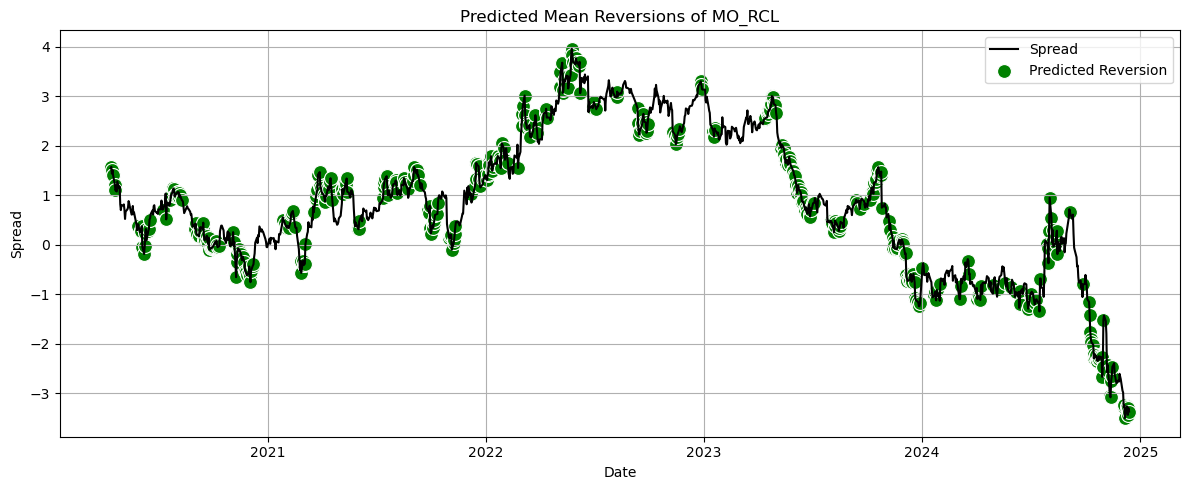

Confusion Matrix:
[[573 130]
 [118 357]]
F1 Score: 0.7422

Training model for pair: MO_HWM
Epoch 1/20 - Loss: 0.8328
Epoch 2/20 - Loss: 0.7126
Epoch 3/20 - Loss: 0.6456
Epoch 4/20 - Loss: 0.5832
Epoch 5/20 - Loss: 0.5769
Epoch 6/20 - Loss: 0.5679
Epoch 7/20 - Loss: 0.5585
Epoch 8/20 - Loss: 0.5088
Epoch 9/20 - Loss: 0.5246
Epoch 10/20 - Loss: 0.5062
Epoch 11/20 - Loss: 0.5055
Epoch 12/20 - Loss: 0.4847
Epoch 13/20 - Loss: 0.4782
Epoch 14/20 - Loss: 0.4644
Epoch 15/20 - Loss: 0.4820
Epoch 16/20 - Loss: 0.4676
Epoch 17/20 - Loss: 0.4549
Epoch 18/20 - Loss: 0.4500
Epoch 19/20 - Loss: 0.4611
Epoch 20/20 - Loss: 0.4413

Evaluating model for pair: MO_HWM
Test Accuracy:  0.6714770797962648


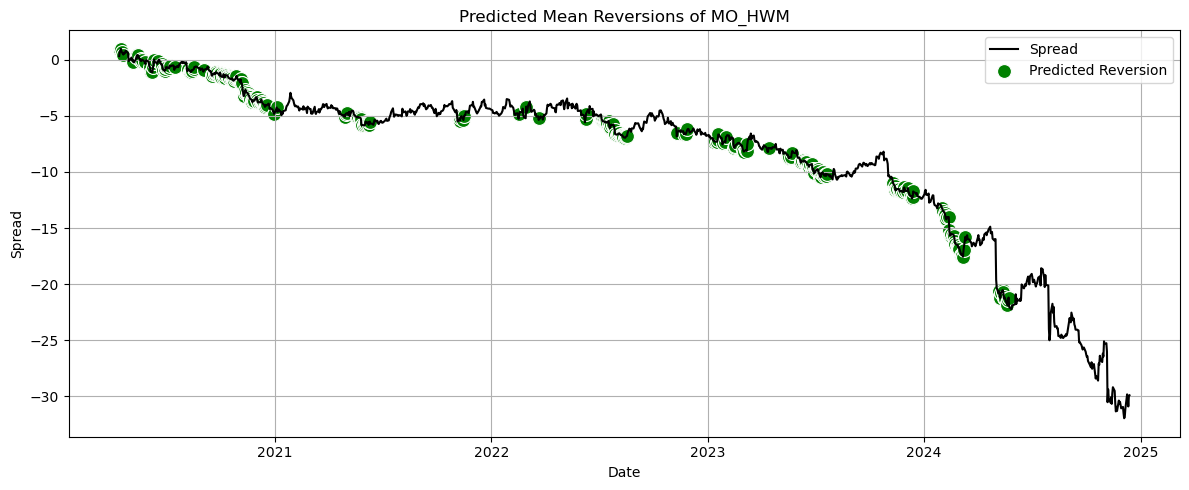

Confusion Matrix:
[[585  87]
 [300 206]]
F1 Score: 0.5156

Training model for pair: MO_BK
Epoch 1/20 - Loss: 0.7847
Epoch 2/20 - Loss: 0.7360
Epoch 3/20 - Loss: 0.6635
Epoch 4/20 - Loss: 0.6304
Epoch 5/20 - Loss: 0.5970
Epoch 6/20 - Loss: 0.5768
Epoch 7/20 - Loss: 0.5756
Epoch 8/20 - Loss: 0.5510
Epoch 9/20 - Loss: 0.5307
Epoch 10/20 - Loss: 0.5228
Epoch 11/20 - Loss: 0.5170
Epoch 12/20 - Loss: 0.5119
Epoch 13/20 - Loss: 0.4985
Epoch 14/20 - Loss: 0.4803
Epoch 15/20 - Loss: 0.4737
Epoch 16/20 - Loss: 0.4585
Epoch 17/20 - Loss: 0.4511
Epoch 18/20 - Loss: 0.4605
Epoch 19/20 - Loss: 0.4581
Epoch 20/20 - Loss: 0.4475

Evaluating model for pair: MO_BK
Test Accuracy:  0.7835314091680815


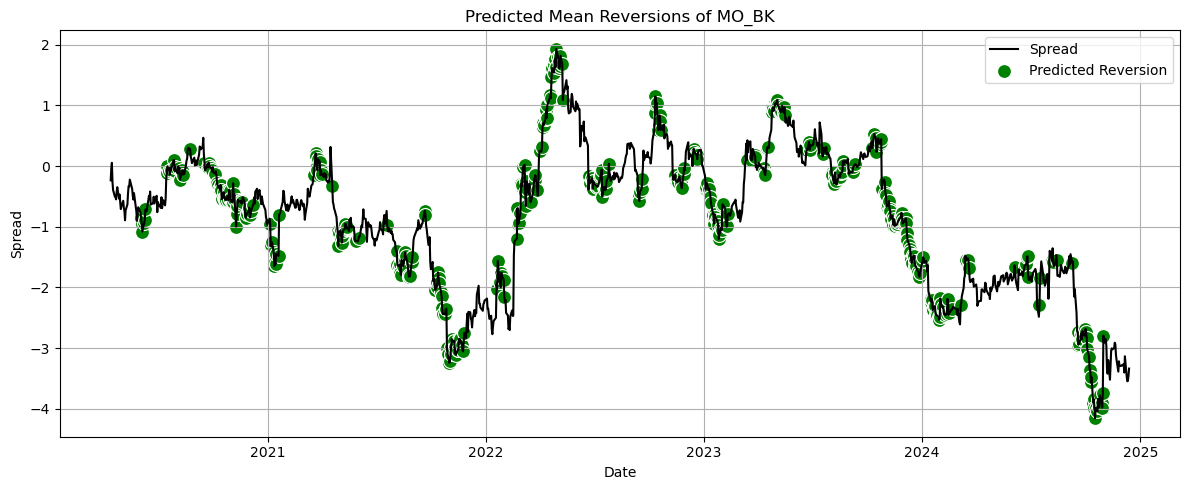

Confusion Matrix:
[[599 134]
 [121 324]]
F1 Score: 0.7176

Training model for pair: F_RCL
Epoch 1/20 - Loss: 0.7565
Epoch 2/20 - Loss: 0.6810
Epoch 3/20 - Loss: 0.6369
Epoch 4/20 - Loss: 0.5901
Epoch 5/20 - Loss: 0.6056
Epoch 6/20 - Loss: 0.5556
Epoch 7/20 - Loss: 0.5311
Epoch 8/20 - Loss: 0.5378
Epoch 9/20 - Loss: 0.5142
Epoch 10/20 - Loss: 0.5044
Epoch 11/20 - Loss: 0.5271
Epoch 12/20 - Loss: 0.4983
Epoch 13/20 - Loss: 0.4945
Epoch 14/20 - Loss: 0.4710
Epoch 15/20 - Loss: 0.4806
Epoch 16/20 - Loss: 0.4863
Epoch 17/20 - Loss: 0.4612
Epoch 18/20 - Loss: 0.4626
Epoch 19/20 - Loss: 0.4522
Epoch 20/20 - Loss: 0.4349

Evaluating model for pair: F_RCL
Test Accuracy:  0.7784380305602716


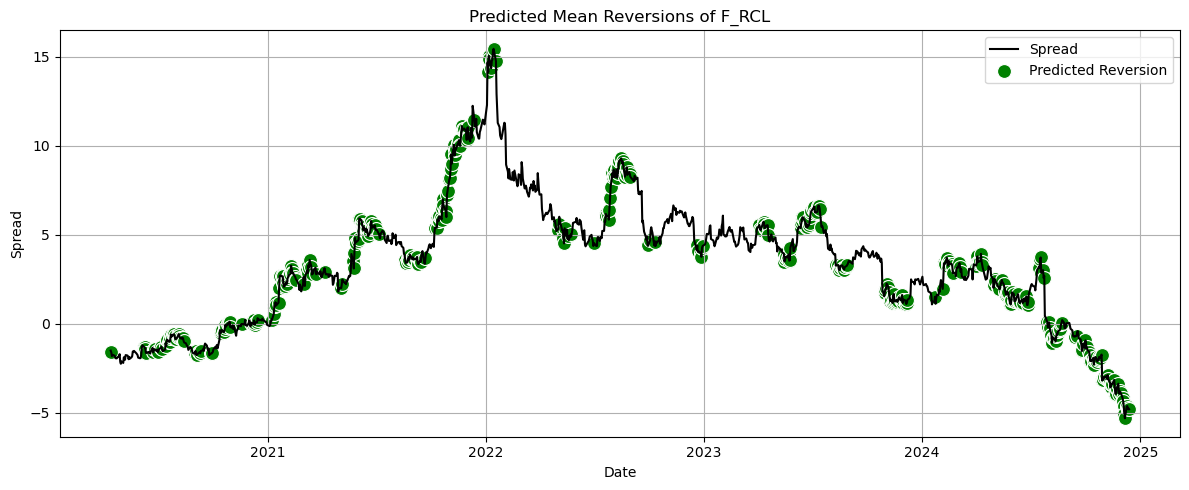

Confusion Matrix:
[[550 115]
 [146 367]]
F1 Score: 0.7377

Training model for pair: F_HWM
Epoch 1/20 - Loss: 0.7467
Epoch 2/20 - Loss: 0.6765
Epoch 3/20 - Loss: 0.6066
Epoch 4/20 - Loss: 0.5909
Epoch 5/20 - Loss: 0.5593
Epoch 6/20 - Loss: 0.5290
Epoch 7/20 - Loss: 0.5343
Epoch 8/20 - Loss: 0.5273
Epoch 9/20 - Loss: 0.5357
Epoch 10/20 - Loss: 0.4922
Epoch 11/20 - Loss: 0.4763
Epoch 12/20 - Loss: 0.4683
Epoch 13/20 - Loss: 0.4556
Epoch 14/20 - Loss: 0.4551
Epoch 15/20 - Loss: 0.4817
Epoch 16/20 - Loss: 0.4862
Epoch 17/20 - Loss: 0.4445
Epoch 18/20 - Loss: 0.4234
Epoch 19/20 - Loss: 0.4171
Epoch 20/20 - Loss: 0.4309

Evaluating model for pair: F_HWM
Test Accuracy:  0.7444821731748726


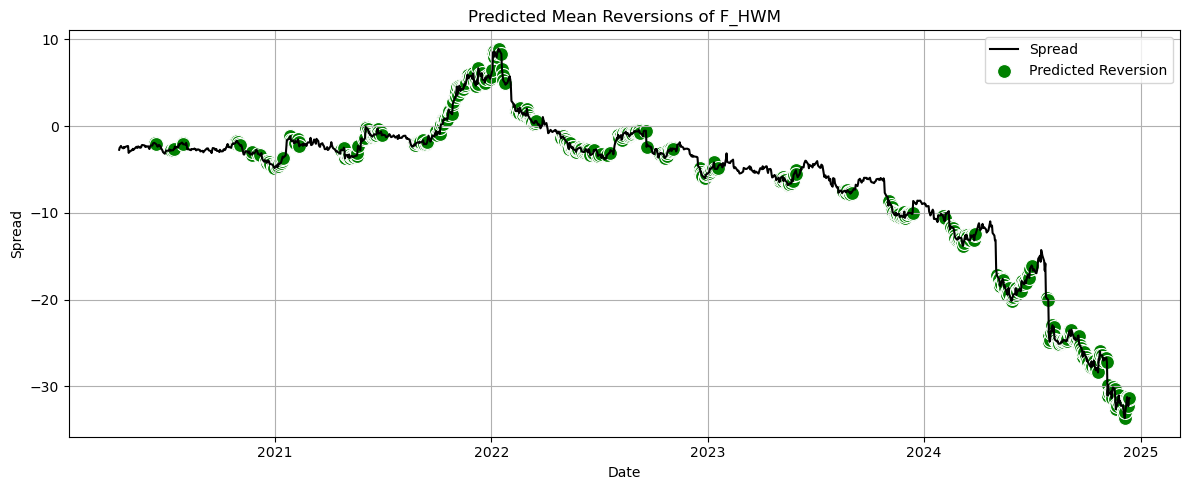

Confusion Matrix:
[[479 152]
 [149 398]]
F1 Score: 0.7256

Training model for pair: F_BK
Epoch 1/20 - Loss: 0.7413
Epoch 2/20 - Loss: 0.6467
Epoch 3/20 - Loss: 0.6340
Epoch 4/20 - Loss: 0.5742
Epoch 5/20 - Loss: 0.5193
Epoch 6/20 - Loss: 0.5144
Epoch 7/20 - Loss: 0.4954
Epoch 8/20 - Loss: 0.4749
Epoch 9/20 - Loss: 0.4779
Epoch 10/20 - Loss: 0.4812
Epoch 11/20 - Loss: 0.4687
Epoch 12/20 - Loss: 0.4496
Epoch 13/20 - Loss: 0.4545
Epoch 14/20 - Loss: 0.4387
Epoch 15/20 - Loss: 0.4504
Epoch 16/20 - Loss: 0.4482
Epoch 17/20 - Loss: 0.4245
Epoch 18/20 - Loss: 0.4321
Epoch 19/20 - Loss: 0.4160
Epoch 20/20 - Loss: 0.3969

Evaluating model for pair: F_BK
Test Accuracy:  0.7546689303904923


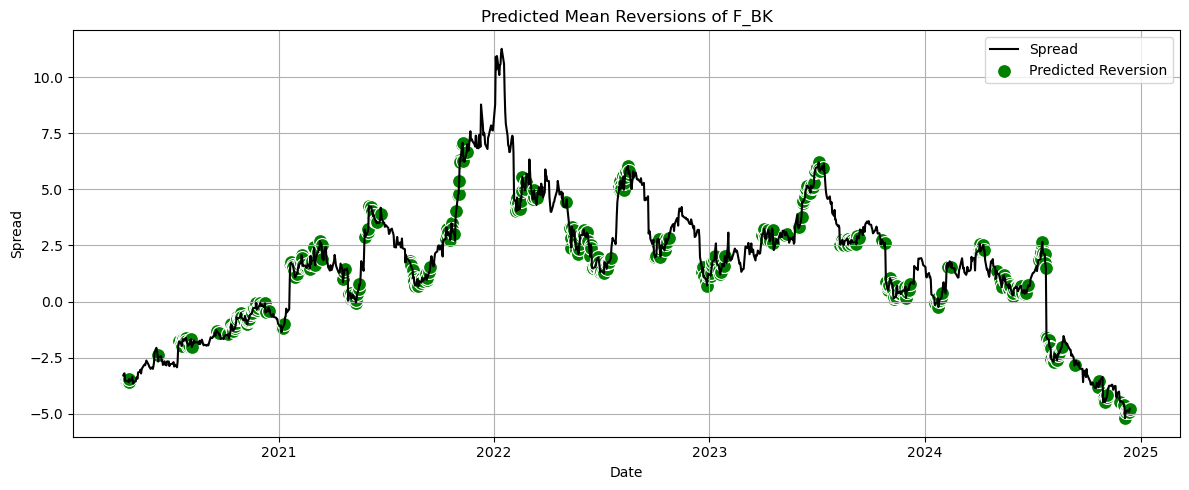

Confusion Matrix:
[[529 115]
 [174 360]]
F1 Score: 0.7136

Training model for pair: STX_RCL
Epoch 1/20 - Loss: 0.7117
Epoch 2/20 - Loss: 0.6557
Epoch 3/20 - Loss: 0.6075
Epoch 4/20 - Loss: 0.5761
Epoch 5/20 - Loss: 0.5454
Epoch 6/20 - Loss: 0.5153
Epoch 7/20 - Loss: 0.5132
Epoch 8/20 - Loss: 0.5091
Epoch 9/20 - Loss: 0.4896
Epoch 10/20 - Loss: 0.4939
Epoch 11/20 - Loss: 0.5094
Epoch 12/20 - Loss: 0.4787
Epoch 13/20 - Loss: 0.4660
Epoch 14/20 - Loss: 0.4764
Epoch 15/20 - Loss: 0.4863
Epoch 16/20 - Loss: 0.4419
Epoch 17/20 - Loss: 0.4499
Epoch 18/20 - Loss: 0.4362
Epoch 19/20 - Loss: 0.4169
Epoch 20/20 - Loss: 0.4386

Evaluating model for pair: STX_RCL
Test Accuracy:  0.730899830220713


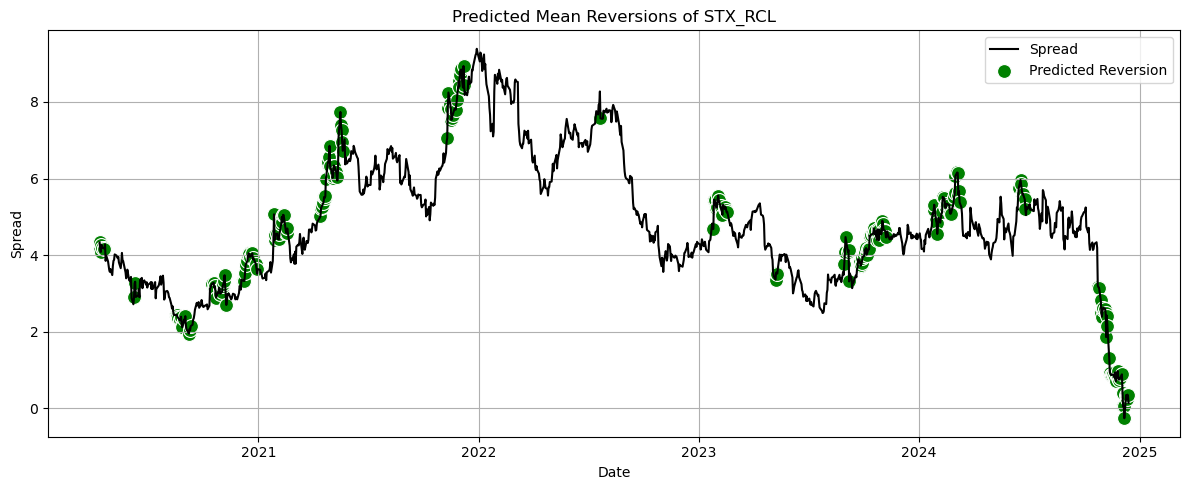

Confusion Matrix:
[[663  43]
 [274 198]]
F1 Score: 0.5554

Training model for pair: STX_HWM
Epoch 1/20 - Loss: 0.7413
Epoch 2/20 - Loss: 0.6913
Epoch 3/20 - Loss: 0.6383
Epoch 4/20 - Loss: 0.5922
Epoch 5/20 - Loss: 0.6281
Epoch 6/20 - Loss: 0.5754
Epoch 7/20 - Loss: 0.5429
Epoch 8/20 - Loss: 0.5176
Epoch 9/20 - Loss: 0.5061
Epoch 10/20 - Loss: 0.5071
Epoch 11/20 - Loss: 0.4712
Epoch 12/20 - Loss: 0.4749
Epoch 13/20 - Loss: 0.4415
Epoch 14/20 - Loss: 0.5145
Epoch 15/20 - Loss: 0.4571
Epoch 16/20 - Loss: 0.4502
Epoch 17/20 - Loss: 0.4177
Epoch 18/20 - Loss: 0.4443
Epoch 19/20 - Loss: 0.4071
Epoch 20/20 - Loss: 0.4156

Evaluating model for pair: STX_HWM
Test Accuracy:  0.700339558573854


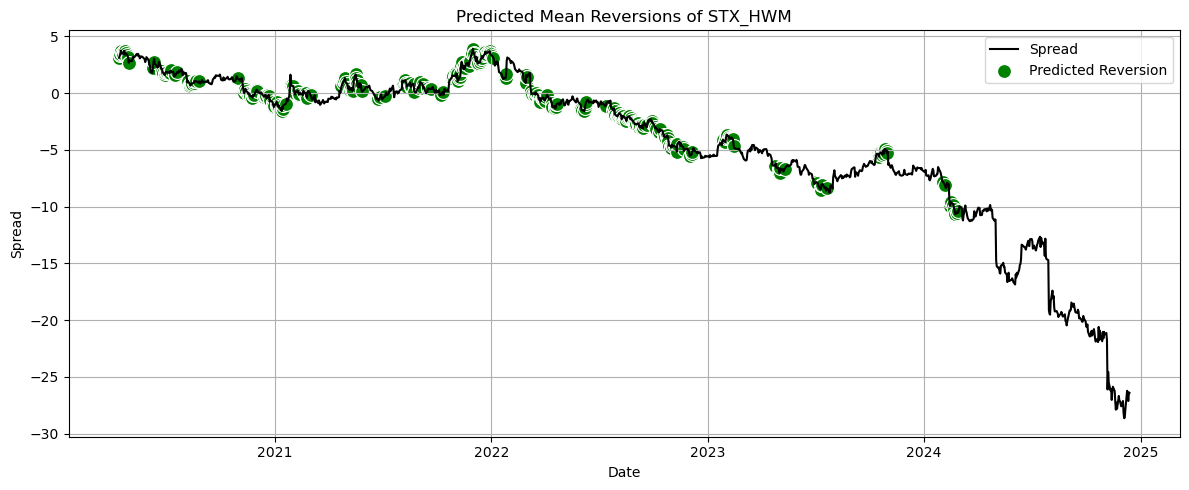

Confusion Matrix:
[[580 101]
 [252 245]]
F1 Score: 0.5813

Training model for pair: STX_BK
Epoch 1/20 - Loss: 0.7560
Epoch 2/20 - Loss: 0.6707
Epoch 3/20 - Loss: 0.6432
Epoch 4/20 - Loss: 0.6072
Epoch 5/20 - Loss: 0.5628
Epoch 6/20 - Loss: 0.5234
Epoch 7/20 - Loss: 0.5130
Epoch 8/20 - Loss: 0.4981
Epoch 9/20 - Loss: 0.4865
Epoch 10/20 - Loss: 0.4836
Epoch 11/20 - Loss: 0.4698
Epoch 12/20 - Loss: 0.4608
Epoch 13/20 - Loss: 0.4734
Epoch 14/20 - Loss: 0.4513
Epoch 15/20 - Loss: 0.4347
Epoch 16/20 - Loss: 0.4322
Epoch 17/20 - Loss: 0.4316
Epoch 18/20 - Loss: 0.4185
Epoch 19/20 - Loss: 0.4119
Epoch 20/20 - Loss: 0.4130

Evaluating model for pair: STX_BK
Test Accuracy:  0.5441426146010186


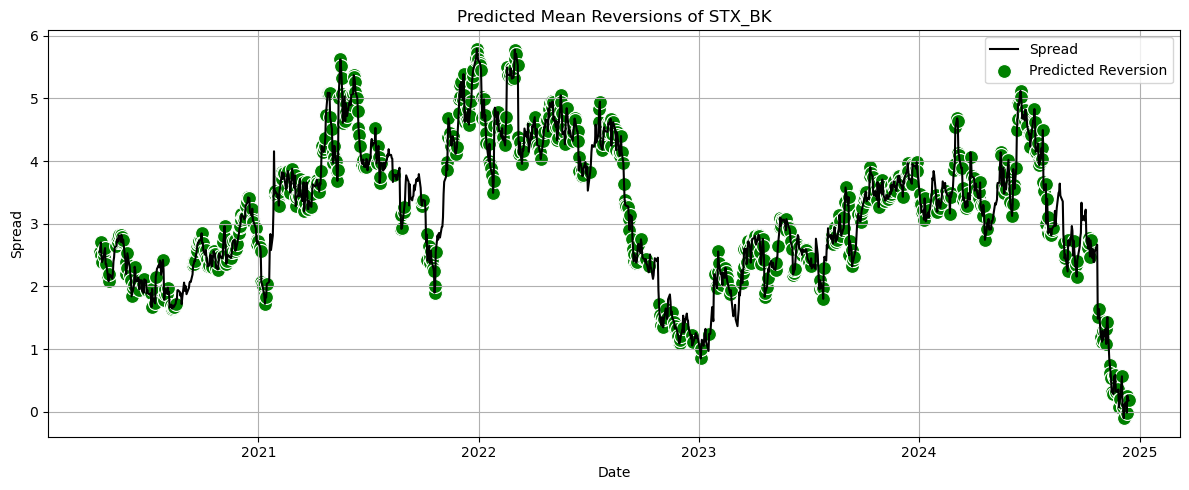

Confusion Matrix:
[[261 470]
 [ 67 380]]
F1 Score: 0.5860
{'MO_RCL': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(1178, 1), dtype=float32), 'y_pred': array([0.79240197, 0.8530599 , 0.8427965 , ..., 0.71289706, 0.7010735 ,
       0.66924876], shape=(1178,), dtype=float32)}, 'MO_HWM': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], shape=(1178, 1), dtype=float32), 'y_pred': array([0.3576062 , 0.41851503, 0.6302757 , ..., 0.48084873, 0.4725078 ,
       0.4801207 ], shape=(1178,), dtype=float32)}, 'MO_BK': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, o

In [28]:
results = {}

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 20,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [29]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [30]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [31]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [32]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 10,
    entry_threshold = 1,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob > 0.5 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [33]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)

    plt.title("LSTM Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(combined_equity['Total'])

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # show last 10 rows for this pair
        print("-" * 40)

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_42127/522340902.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')


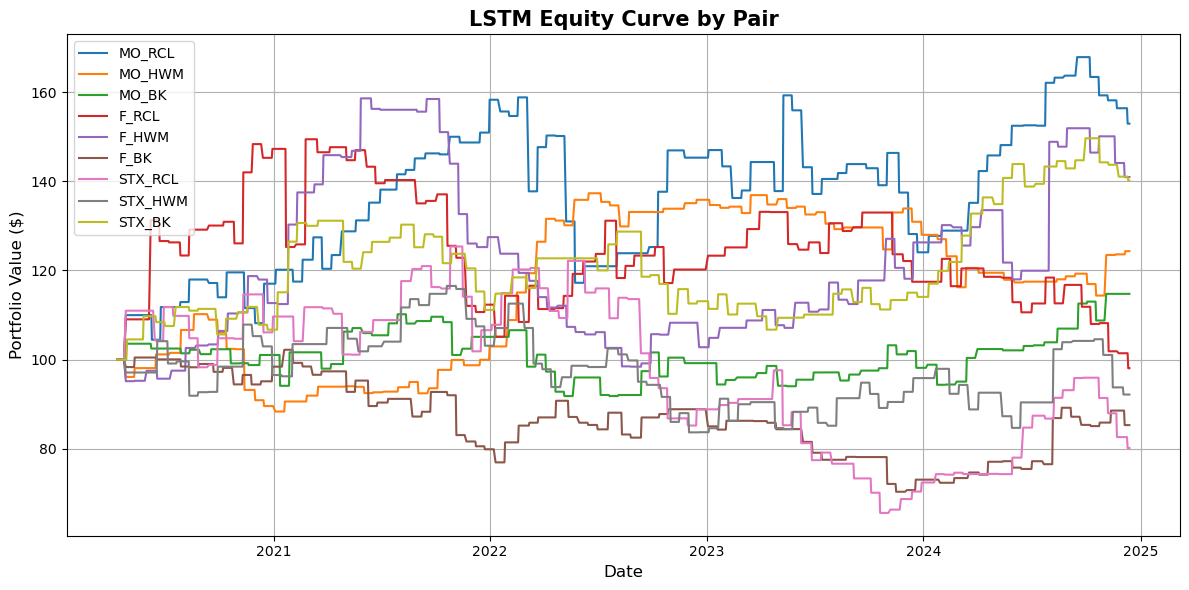


Final Portfolio Value: $1,028.95

Trade Summary:
  MO_RCL: 82 trades | Total PnL: $52.93 | Avg PnL: $0.65
  MO_HWM: 85 trades | Total PnL: $24.33 | Avg PnL: $0.29
  MO_BK: 75 trades | Total PnL: $14.76 | Avg PnL: $0.20
  F_RCL: 81 trades | Total PnL: $-1.92 | Avg PnL: $-0.02
  F_HWM: 82 trades | Total PnL: $40.95 | Avg PnL: $0.50
  F_BK: 81 trades | Total PnL: $-14.67 | Avg PnL: $-0.18
  STX_RCL: 84 trades | Total PnL: $-19.80 | Avg PnL: $-0.24
  STX_HWM: 80 trades | Total PnL: $-7.81 | Avg PnL: $-0.10
  STX_BK: 84 trades | Total PnL: $40.16 | Avg PnL: $0.48

Year-End Portfolio Values:
                MO_RCL      MO_HWM       MO_BK       F_RCL       F_HWM  \
Date                                                                     
2020-12-31  117.040495   89.600328  101.057356  147.267503  112.690507   
2021-12-31  158.290010  102.970686  105.120189  112.336800  127.480862   
2022-12-31  145.298341  135.852207   99.223149  120.214383  102.794619   
2023-12-31  124.076171  127.992787  

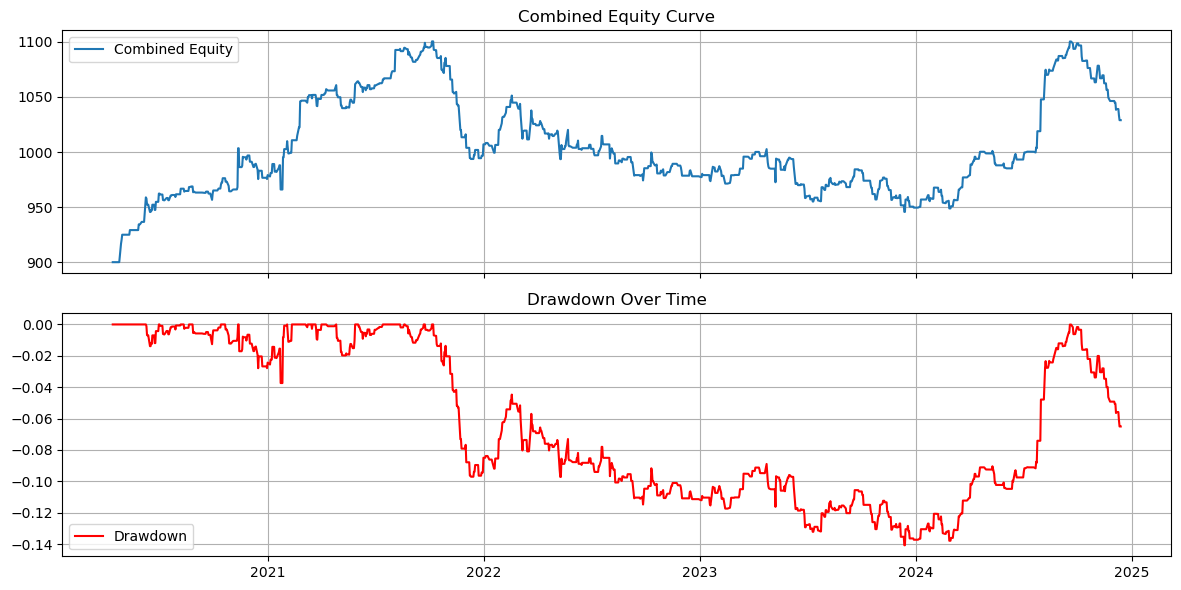

Pair: MO_RCL
Date
2024-12-02    156.379946
2024-12-03    156.379946
2024-12-04    156.379946
2024-12-05    156.379946
2024-12-06    156.379946
2024-12-09    156.379946
2024-12-10    152.929787
2024-12-11    152.929787
2024-12-12    152.929787
2024-12-13    152.929787
Name: MO_RCL, dtype: float64
----------------------------------------
Pair: MO_HWM
Date
2024-12-02    123.614370
2024-12-03    123.614370
2024-12-04    123.614370
2024-12-05    123.614370
2024-12-06    124.334668
2024-12-09    124.334668
2024-12-10    124.334668
2024-12-11    124.334668
2024-12-12    124.334668
2024-12-13    124.334668
Name: MO_HWM, dtype: float64
----------------------------------------
Pair: MO_BK
Date
2024-12-02    114.760229
2024-12-03    114.760229
2024-12-04    114.760229
2024-12-05    114.760229
2024-12-06    114.760229
2024-12-09    114.760229
2024-12-10    114.760229
2024-12-11    114.760229
2024-12-12    114.760229
2024-12-13    114.760229
Name: MO_BK, dtype: float64
-----------------------------

In [34]:
run_simulation(results, X_test_dict, testing_data)